In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import torch
torch.manual_seed(0)

%load_ext autoreload 
%autoreload 2
%config InlineBackend.figure_format = 'retina'

/home/gridsan/mmurphy/.conda/envs/HumanProteinAtlas/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Our manual mapping of cell types in "Single cell transcriptional and chromatin accessibility profiling redefine cellular heterogeneity in the adult human kidney" to anatomical regions in "The kidney transcriptome and proteome defined by transcriptomics and antibody-based profiling".

In [2]:
hpa_mapping = pd.Series({
    'epithelial cell of proximal tubule':'proximal tubule',
    'fibroblast':None,
    'glomerular visceral epithelial cell':'glomerulus',
    'kidney capillary endothelial cell':'glomerulus',
    'kidney connecting tubule epithelial cell':'distal tubule',
    'kidney distal convoluted tubule epithelial cell':'distal tubule',
    'kidney loop of Henle thick ascending limb epithelial cell':'distal tubule',
    'leukocyte':None,
    'mesangial cell':'glomerulus',
    'parietal epithelial cell':'glomerulus',
    'renal alpha-intercalated cell':'collecting duct',
    'renal beta-intercalated cell':'collecting duct',
    'renal principal cell':'collecting duct'
},name='region')

Marker proteins of anatomical regions listed in "The kidney transcriptome and proteome defined by transcriptomics and antibody-based profiling".

In [3]:
hpa_markers = pd.read_csv('./data/hpa_markers.csv',comment='#')
gene_symbols = pd.read_table('./data/gene_symbols.tsv').iloc[:,[0,-1]]
hpa_markers = hpa_markers.merge(gene_symbols,
                                left_on='gene',right_on='Approved symbol',how='inner')
hpa_markers = hpa_markers.set_index(hpa_markers.columns[-1])[['region','gene']]
hpa_markers

,region,gene
Ensembl ID(supplied by Ensembl),,
ENSG00000128567,glomerulus,PODXL
ENSG00000158457,glomerulus,TSPAN33
ENSG00000113578,glomerulus,FGF1
ENSG00000116218,glomerulus,NPHS2
ENSG00000198743,glomerulus,SLC5A3
...,...,...
ENSG00000105707,collecting duct,HPN
ENSG00000214128,collecting duct,TMEM213
ENSG00000100362,collecting duct,PVALB


Load embeddings and normalized per-cell-type mean scRNA expression of each gene.

In [4]:
embeddings = np.load('./data/kidney_embeddings.npy')
index = !cat './data/kidney_embeddings.txt'
embeddings = pd.DataFrame(embeddings,index=index)
rna = pd.read_csv('./data/kidney_rna.csv',index_col=0)
df = pd.read_csv('./data/hpa_v21_kidney.csv',index_col=0)
adata = embeddings.join(df, how='inner')
adata = sc.AnnData(adata[embeddings.columns], obs=adata[df.columns])
adata.var_names = pd.Series(range(adata.shape[1])).astype(str)
adata.obs = adata.obs.join(rna, on='Gene', how='left')

adata

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 66138 × 128
    obs: 'Batch', 'Slide', 'Well', 'Tissue', 'Gene name', 'Gene', 'UniProt', 'Antibody', 'nTPM', 'Staining', 'Sex', 'Age', 'Patient', 'URL', 'Level', 'Reliability', 'epithelial cell of proximal tubule', 'fibroblast', 'glomerular visceral epithelial cell', 'kidney capillary endothelial cell', 'kidney connecting tubule epithelial cell', 'kidney distal convoluted tubule epithelial cell', 'kidney loop of Henle thick ascending limb epithelial cell', 'leukocyte', 'mesangial cell', 'parietal epithelial cell', 'renal alpha-intercalated cell', 'renal beta-intercalated cell', 'renal principal cell'

Hold out images of marker proteins.

In [5]:
train_genes = set(adata.obs.dropna()['Gene'])
test_genes = train_genes & set(hpa_markers.index)
train_genes = train_genes - set(hpa_markers['gene'])

train_mask = adata.obs['Gene'].isin(train_genes)
test_mask = adata.obs['Gene'].isin(test_genes)

cell_types = list(hpa_mapping.index)

X_train = adata[train_mask].to_df() # embeddings
Y_train = adata[train_mask].obs[cell_types].copy() # RNA

X_test = adata[test_mask].to_df()
Y_test = adata[test_mask].obs[cell_types].copy()

sum(train_mask), sum(test_mask)

(51410, 578)

Fit softmax linear model using gradient descent.

In [6]:
from src.classifier import SoftmaxRegression, platt_scaling

clf = SoftmaxRegression(max_iters=1000, lr=0.01, verbose=True)
clf.fit(X_train, Y_train)

Y_pred_test = clf.predict_proba(X_test)
Y_pred_test /= Y_pred_test.sum(1,keepdims=True)
Y_pred_test = pd.DataFrame(Y_pred_test, index=X_test.index, columns=Y_test.columns)

100%|██████████| 1000/1000 [00:01<00:00, 947.10it/s]


# need to use the Wilcoxon stats, not the means!!! + COMET

In [7]:
true_regions = hpa_markers.reset_index().pivot(index=hpa_markers.index.name,columns='region')['gene']
true_regions = true_regions.fillna(0).astype(bool).astype(int)
true_regions

region,collecting duct,distal tubule,glomerulus,proximal tubule
Ensembl ID(supplied by Ensembl),,,,
ENSG00000004948,0,0,0,1
ENSG00000007216,0,0,0,1
ENSG00000008196,0,1,0,0
ENSG00000010932,0,0,0,1
ENSG00000015413,0,0,0,1
...,...,...,...,...
ENSG00000204653,0,0,0,1
ENSG00000214128,1,0,0,0
ENSG00000235961,0,0,0,1


In [8]:
simclr_regions = Y_pred_test.join(adata.obs['Gene']).groupby('Gene').mean().dropna()
simclr_regions = simclr_regions.T.join(hpa_mapping).groupby('region').sum().T
simclr_regions = simclr_regions.join(hpa_markers[[]],how='right').dropna()
simclr_regions = simclr_regions / simclr_regions.sum(1).values[:,None]
simclr_regions = platt_scaling(simclr_regions, true_regions)
simclr_regions

region,collecting duct,distal tubule,glomerulus,proximal tubule
ENSG00000158296,0.040221,1.121956e-07,4.473970e-01,0.512381
ENSG00000140675,0.001071,1.449277e-22,1.990453e-06,0.998927
ENSG00000168679,0.015651,3.769491e-04,2.118509e-04,0.983760
ENSG00000080493,0.000102,1.421773e-09,1.064027e-09,0.999898
ENSG00000016391,0.004108,4.637064e-20,1.165915e-05,0.995880
...,...,...,...,...
ENSG00000074803,0.106387,6.918703e-03,3.154363e-01,0.571258
ENSG00000109667,0.123278,7.465099e-01,1.600639e-15,0.130212
ENSG00000056736,0.001858,4.611767e-06,7.490302e-10,0.998138
ENSG00000169344,0.312358,3.943602e-01,5.774092e-05,0.293224


In [9]:
rna_regions = Y_test.join(adata.obs['Gene']).groupby('Gene').mean().dropna()
rna_regions = rna_regions.T.join(hpa_mapping).groupby('region').sum().T
rna_regions = rna_regions.join(hpa_markers[[]],how='right').dropna()
rna_regions = rna_regions / rna_regions.sum(1).values[:,None]
rna_regions = platt_scaling(rna_regions, true_regions)
rna_regions

region,collecting duct,distal tubule,glomerulus,proximal tubule
ENSG00000158296,6.772104e-04,0.000083,0.001858,0.997382
ENSG00000140675,1.697448e-03,0.000023,0.000731,0.997548
ENSG00000168679,3.943547e-03,0.001792,0.026163,0.968101
ENSG00000080493,4.716524e-33,0.000165,0.007265,0.992570
ENSG00000016391,1.340239e-02,0.000183,0.001586,0.984829
...,...,...,...,...
ENSG00000074803,1.125545e-02,0.504552,0.056310,0.427883
ENSG00000109667,6.405746e-06,0.000195,0.003891,0.995908
ENSG00000056736,1.140887e-03,0.000161,0.005489,0.993209
ENSG00000169344,1.032185e-02,0.640128,0.215483,0.134066


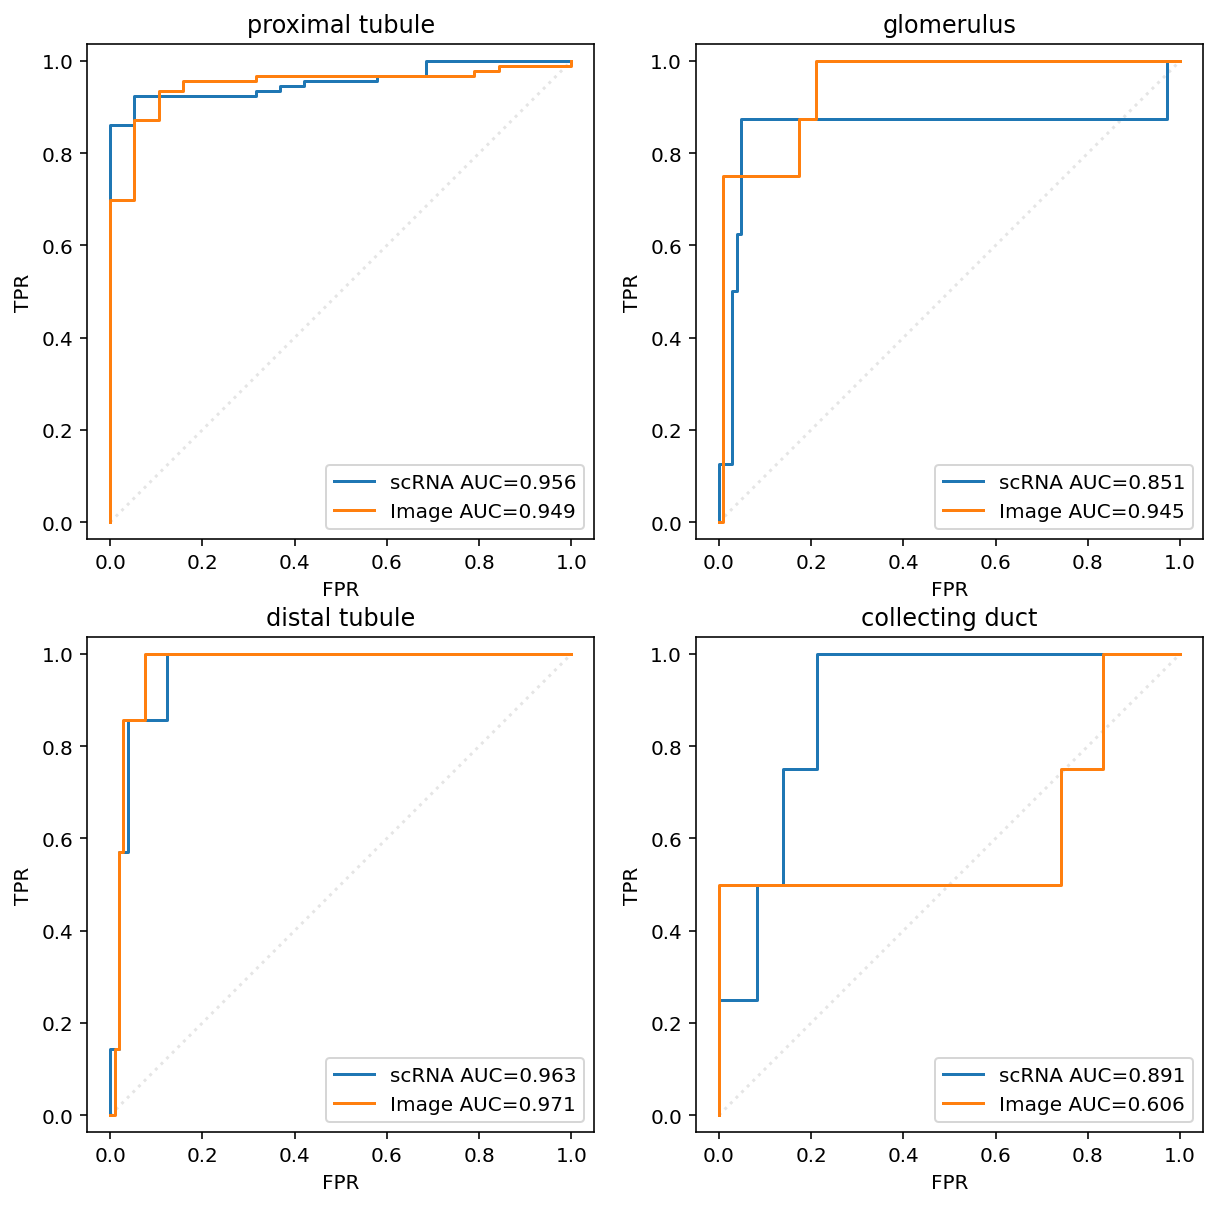

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score

regions = true_regions.sum().sort_values(ascending=False).index.tolist()

figsize = 5
fig,axs = plt.subplots(2,len(regions)//2,figsize=(len(regions)//2*figsize,2*figsize))
axs=axs.ravel()
for ax,region in zip(axs,regions):
    ax.plot([0,1],[0,1],'k:',alpha=0.1)
    ax.set_title(region)

    name = 'scRNA'
    y = true_regions[region]
    y_pred = simclr_regions[region]
    idx = list(set(y.index)&set(y_pred.index))
    y, y_pred = y[idx], y_pred[idx]
    fpr, tpr, thr = roc_curve(y,y_pred)
    auc = roc_auc_score(y,y_pred)
    ax.plot(fpr,tpr,label=f'{name} AUC=%.3f'%auc)
    
    name = 'Image'
    y = true_regions[region]
    y_pred = rna_regions[region]
    idx = list(set(y.index)&set(y_pred.index))
    y, y_pred = y[idx], y_pred[idx]
    fpr, tpr, thr = roc_curve(y,y_pred)
    auc = roc_auc_score(y,y_pred)
    ax.plot(fpr,tpr,label=f'{name} AUC=%.3f'%auc)
    
    ax.axis('equal')
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.legend()